# Landslide detection using SAR dataset

The following code is extracted from [this paper](https://doi.org/10.3390/rs14061449). 
The dataset used in this code is available here: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide-detection-using-sar-dataset/data

## Installation of dependencies

In [ ]:
!pip install segmentation-models rasterio

In [2]:
import cv2 
import time
import os
import h5py
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, add, multiply, Lambda
from tensorflow.keras.layers import AveragePooling2D, average, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.initializers import glorot_normal, random_normal, random_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.applications import VGG19, densenet
from tensorflow.keras.models import load_model

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code
kinit = 'glorot_normal'


def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x
	

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x


Segmentation Models: using `keras` framework.


In [3]:
import tensorflow.keras.backend as K

smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

In [4]:
# Load data
X_train = np.load(f'/content/data/trainX.npy')
Y_train = np.load(f'/content/data/trainY.npy')
X_test = np.load(f'/content/data/testX.npy')
Y_test = np.load(f'/content/data/testY.npy')

In [5]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((752, 64, 64, 4), (752, 64, 64, 1), (189, 64, 64, 4), (189, 64, 64, 1))

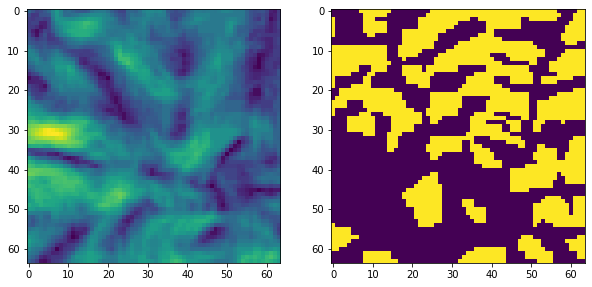

In [10]:
i=11

f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(X_test[i][:,:,3])
axarr[1].imshow(np.squeeze(Y_test[i]))

In [11]:
# define matrics
metrics = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1),sm.metrics.IOUScore(threshold=0.5)]

In [ ]:
# Model training - Results are saved in a .csv file

# Size of the tiles
size = 64
# Image bands
img_bands = X_train.shape[3]
# Sampling method
sampling = "no_overlap"
# Number of filters 
filters = [4, 8, 16, 32]
# Learning rates
lr = [10e-3, 5e-4, 10e-4, 5e-5, 10e-5]
# Batch sizes 
batch_size = [4, 8, 16, 32]
# Epochs
epochs = 200

# Dictionary that will save the results
dic = {}

# Hyperparameters
dic["model"] = []
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []

# test area 1
dic["precision_area"] = []
dic["recall_area"] = []
dic["f1_score_area"] = []
dic["iou_score_area"] = []

# loop over all the filters in the filter list
for fiilter in filters:
    # loop over the learning rates
    for learning_rate in lr:
        # loop over all batch sizes in batch_size list
        for batch in batch_size:
            def attn_unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):   
                inputs = Input(shape=input_size)
                conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=True, name='conv1')
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

                conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=True, name='conv2')
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

                conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=True, name='conv3')
                #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

                conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=True, name='conv4')
                #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=True, name='center')

                g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
                attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, '_1')
                up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')

                g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
                attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, '_2')
                up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

                g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
                attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, '_3')
                up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

                up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
                conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)

                model = Model(inputs, conv10)

                model.compile(optimizer = Adam(lr = lr), loss = dice_loss, metrics = metrics)
                model.summary()

                if(pretrained_weights):
                    model.load_weights(pretrained_weights)

                return model



            # Load the model
            model = attn_unet(filtersFirstLayer= fiilter, lr = learning_rate, input_size = (size,size,img_bands))
            # Stop the training if the validation loss does not decrease after 30 epochs
            early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 30, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the mod
            # Save the models only when validation loss decrease
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'data/weights/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5', monitor='val_loss', mode='min',verbose=1, save_best_only=True,save_weights_only = True)
            print(fiilter, learning_rate,batch)
            # fit the model 20% of the dataset was used as validation
            history = model.fit(X_train,Y_train,batch_size = batch,epochs=epochs,validation_split=0.2,callbacks = [model_checkpoint, early_stop])

            # summarize history for iou score
            plt.plot(history.history['f1-score'])
            plt.plot(history.history['val_f1-score'])
            plt.title('model f1-score')
            plt.ylabel('f1-score')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            # save plots 
            plt.savefig(f"data/plots/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_iou_score.png")
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.savefig(f"data/plots/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_val_loss.png")
            plt.show()
            
            # load unet to evaluate the test data
            attn_unet = attn_unet(filtersFirstLayer= fiilter, lr = learning_rate,input_size=(size,size,img_bands))
            # load the last saved weight from the training
            attn_unet.load_weights(f"data/weights/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5")
            
           # Evaluate the model
            res_1= attn_unet.evaluate(X_test,Y_test)


            # save results on the dictionary
            dic["model"].append("Attention_Unet")
            dic["batch_size"].append(batch)
            dic["learning_rate"].append(learning_rate)
            dic["filters"].append(fiilter)
            dic["precision_area"].append(res_1[1])
            dic["recall_area"].append(res_1[2])
            dic["f1_score_area"].append(res_1[3])
            dic["iou_score_area"].append(res_1[4])
            


            # Convert results to a dataframe
            results = pd.DataFrame(dic)
            # Export as csv
            results.to_csv(f'data/results/results_Att_Unet.csv', index = False)

In [14]:
def attn_unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):   
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=True, name='conv3')
    #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=True, name='conv4')
    #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=True, name='center')

    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, '_1')
    up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')

    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, '_2')
    up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, '_3')
    up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = lr), loss = dice_loss, metrics = metrics)
    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
# Load the best model based on the best performances on the test set (check CSV file)
# Loading the model weights
size = 64
img_bands=4
print(size, img_bands)
attn_unet_best = attn_unet(filtersFirstLayer=4, lr = 0.001, input_size =(size,size,img_bands))
print(attn_unet_best.summary())
attn_unet_best.load_weights("data/weights/unet_no_overlap_size_64_filters_4_batch_size_4_lr_0.001.hdf5")

In [ ]:
# Plot predictions on test set
for i in range(X_test.shape[0]):
    preds_train_1 = attn_unet_best.predict(np.expand_dims(X_test[i],axis = 0), verbose=1)
    # It's possible to change the 0.5 threshold to improve the results;
    preds_train_t1 = (preds_train_1 > 0.5).astype(np.uint8)
    f, axarr = plt.subplots(1,3,figsize=(10,10))
    axarr[0].imshow(X_test[i][:,:,0])
    axarr[1].imshow(np.squeeze(preds_train_t1))
    axarr[2].imshow(np.squeeze(Y_test[i]))
    



In [ ]:
! zip -r "/content/output.zip" "/content/data"